# Time series from FOCI-OpenIFS piControl and correlation on PC1 of North Atlantic SST variability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal, stats
import seaborn as sns
import string
from eofs.xarray import Eof

In [2]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

In [4]:
from dask.distributed import Client, LocalCluster, wait

In [5]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38955 instead
  expected, actual


In [6]:
client

Client Scheduler: tcp://127.0.0.1:38705 Dashboard: http://127.0.0.1:38955/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [31]:
#plt.style.use('dark_background')
#dark='_dark'
plt.style.use('default')
dark=''
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [8]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read NEMO mesh

In [9]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

## Read NEMO stream functions

In [10]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

In [11]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    lat = ds_moc['nav_lat'][0,:,0].data # .data is required in newer xarray versions
    ds_moc_lat = ds_moc.assign_coords(lat=("y", lat)) # add latitude to stream functions
    ds_moc_all.append(ds_moc_lat)
    
    psi = '%s/%s/outdata/nemo/cdf_analysis/%s*1y*PSI_r360x180.nc' % (esmdir,exp,exp)
    print(psi)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1y*PSI_r360x180.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1y*PSI_r360x180.nc


In [12]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [13]:
ds_psi

<xarray.Dataset>
Dimensions:            (time: 2100, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    sobarstf           (time, lat, lon) float32 dask.array<chunksize=(1000, 180, 360), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.9 (https://mpimet.m...
    Conventions:       CF-1.6
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Thu Dec 08 16:09:49 2022: cdo -v -mergetime -remapbil,...
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....
    frequency:         year
    CDO:               Climate Data Operators version 1.9.9 (https://mpimet.m...

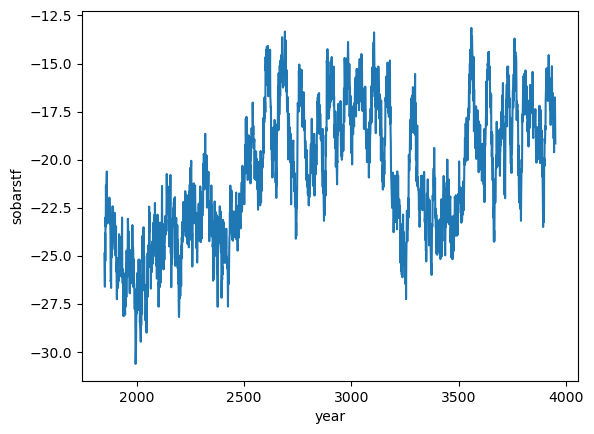

In [14]:
# subpolar gyre
lon1, lon2 = -55, -30
lat1, lat2 = 50, 60
_s = ds_psi['sobarstf'].sel(lon=slice(305,330), lat=slice(50,60)) * 1e-6
da_spg = wgtm(_s).groupby('time.year').mean('time').compute()
da_spg.plot()

In [15]:
# save to file
ds_spg = da_spg.to_dataset()
ds_spg.to_netcdf('data/SPG_1850-3999.nc')

In [15]:
# read from file
#da_spg = xr.open_dataset('data/SPG_1850-3999.nc', use_cftime=True)['sobarstf']
da_spg = xr.open_dataset('data/SPG_new_1850_3999.nc', use_cftime=True)['spg_amp']
da_spg

<xarray.DataArray 'spg_amp' (time: 1000)>
array([-41376428., -45117196., -46454720., ..., -32061576., -35445396.,
       -34636090.], dtype=float32)
Coordinates:
  * time     (time) object 1850-07-01 00:00:00 ... 2849-07-01 00:00:00

## Read NEMO transport sections

In [17]:
# NEMO transports
ds_trp_all = []

for exp,time in zip(exp_list,time_list):
    
    _ds_trp_all = []
    for sec in ['DENMARK_STRAIT','DRAKE','FRAM','ICELAND_SCOTLAND']:
        sec_l = sec.lower()
        if sec == 'ICELAND_SCOTLAND':
            sec_l = 'icsco'
        elif sec == 'DENMARK_STRAIT':
            sec_l = 'denma'
            
        vname = 'vtrp_%s' % (sec_l,)
        trp = '%s/%s/derived/nemo/%s*1y*%s*.nc' % (esmdir,exp,exp,sec)
        print(trp)
        _ds_trp = xr.open_mfdataset(trp,combine='by_coords',use_cftime=True).rename({'time_counter':'time', vname:'vtrp'}).sel(time=time).sel(x=0,y=0)['vtrp']
        _ds_trp['section'] = sec
        _ds_trp_all.append(_ds_trp)
        
    _ds_sec = xr.concat( _ds_trp_all, dim='section' )
    ds_trp_all.append(_ds_sec)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/derived/nemo/FOCI_GJK001*1y*DENMARK_STRAIT*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/derived/nemo/FOCI_GJK001*1y*DRAKE*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/derived/nemo/FOCI_GJK001*1y*FRAM*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/derived/nemo/FOCI_GJK001*1y*ICELAND_SCOTLAND*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/derived/nemo/FOCI_GJK006*1y*DENMARK_STRAIT*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/derived/nemo/FOCI_GJK006*1y*DRAKE*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/derived/nemo/FOCI_GJK006*1y*FRAM*.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/derived/nemo/FOCI_GJK006*1y*ICELAND_SCOTLAND*.nc


In [18]:
ds_trp = xr.concat(ds_trp_all, dim='time').groupby('time.year').mean('time')

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWa

In [19]:
ds_trp#.sel(section='DENMARK_STRAIT').plot()

<xarray.DataArray 'vtrp' (section: 4, year: 2100)>
dask.array<transpose, shape=(4, 2100), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * section  (section) <U16 'DENMARK_STRAIT' 'DRAKE' 'FRAM' 'ICELAND_SCOTLAND'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949

## Read OpenIFS data

Read in monthly in case we want to look at seasonal variables

In [20]:
# OpenIFS surface
ds_sfc_1m_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1m_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/*1m*regular_sfc.nc


In [21]:
ds_sfc_1m = xr.concat( ds_sfc_1m_all, dim='time' )

## Read OpenIFS annual mean

In [22]:
# OpenIFS surface
ds_sfc_1y_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_1y_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [23]:
ds_sfc_1y = xr.concat( ds_sfc_1y_all, dim='time' )

In [24]:
scale = 180./(np.pi * 6371e3) # scale d/dphi -> d/dy
# d/dy(tau_x) - d/dx(tau_y) 
# centered differences
taux_y = ds_sfc_1y['ewss'].differentiate('lat') * scale # dtaux/dy 
tauy_x = ds_sfc_1y['nsss'].differentiate('lon') * scale * np.cos( np.deg2rad(ds_sfc['lat']) ) # dtauy/dx 
# stress is N/m2*s. Divide by seconds to get N/m2. 
da_curl_1y = ((taux_y - tauy_x) / (6.0*60*60)) #[N/m3]

# mean over spg
da_curl_spg_1y = wgtm(da_curl_1y.sel(lon=slice(305,330), lat=slice(50,60))).groupby('time.year').mean('time').compute()


In [25]:
# save to file
da_curl_spg_1y.name = 'curl'
ds_curl = da_curl_spg_1y.to_dataset()
ds_curl.to_netcdf('data/uv_curl_SPG_1850-3999.nc')

In [16]:
# read from file
da_curl_spg_1y = xr.open_dataset('data/uv_curl_SPG_1850-3999.nc', use_cftime=True)['curl']
da_curl_spg_1y

<xarray.DataArray 'curl' (year: 2100)>
array([-7.837024e-08, -6.855702e-08, -1.158879e-07, ..., -5.466998e-08,
       -9.786385e-08, -1.544660e-07], dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949

## Read PC1 of Natl SST

In [17]:
pc1_sst = xr.open_dataset('data/EOF_PC_10_NAtl_1850-3999.nc', use_cftime=True)['pcs'].sel(mode=0).groupby('time.year').mean('time')
pc1_sst

<xarray.DataArray 'pcs' (year: 2140)>
array([ 0.0681965 , -0.07989622, -0.14453748, ...,  0.79316414,
        0.84495412,  0.86737443])
Coordinates:
    mode     int64 0
  * year     (year) int64 1855 1856 1857 1858 1859 ... 3990 3991 3992 3993 3994

## Read PC1 of NAtl thf

In [18]:
pc1_thf = xr.open_dataset('data/EOF_PC_10_THF_NAtl_1850-3999.nc', use_cftime=True)['pcs'].sel(mode=0).groupby('time.year').mean('time')
pc2_thf = xr.open_dataset('data/EOF_PC_10_THF_NAtl_1850-3999.nc', use_cftime=True)['pcs'].sel(mode=1).groupby('time.year').mean('time')

## Make some time series

* Global mean T2M
* AMOC at 45N
* AMV

### NAO

In [29]:
# First shift from 0,360 lon to -180,180 so we can select area across prime meridian
msl = ds_sfc_1m['msl'].assign_coords(lon=(((ds_sfc_1m['lon'] + 180) % 360) - 180)).sortby('lon')

# Select North Atlantic 
msl_na = msl.sel(lon=slice(-80,40), lat=slice(20,90))

# Resample to quarters starting in Dec, 
# then skip the first year (where we only have Jan-Feb) 
# and the last (where we only have Dec) and take every 4 steps
msl_djf = msl_na.resample(time='QS-DEC').mean('time')[4:-4:4]

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs

In [30]:
# Anomalies
msl_djf_a = msl_djf - msl_djf.mean(dim='time')

# Then load data into memory and detrend
_detrend = detrend(msl_djf_a.load())

# Make sure time is first dimension (this is needed for EOF functions)
msl_djf_det = _detrend.transpose("time",...)

# Set latitude weights and configure the EOF
coslat = np.cos(np.deg2rad(msl_djf_det.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(msl_djf_det, weights=wgts)

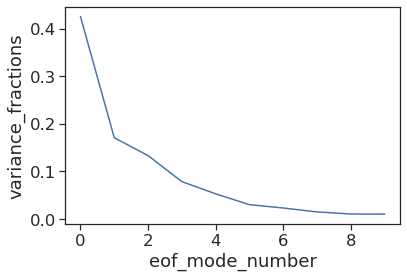

In [31]:
# Check how much variance is explained by modes
expvar = solver.varianceFraction(neigs=10)
expvar.plot()

In [32]:
# Get EOF1 and PC1. Multiply by -1 to get the usual pattern
eof1_nao = solver.eofs(neofs=1, eofscaling=1).drop('mode') * -1
pc1_nao = solver.pcs(npcs=1, pcscaling=1).groupby('time.year').mean('time').drop('mode').squeeze() * -1

In [33]:
# Write result to disk
ds_eof = eof1_nao.to_dataset()
ds_pc = pc1_nao.to_dataset()
ds = xr.merge([ds_eof,ds_pc])
ds.to_netcdf('data/EOF_PC_1_NAO_1850-3999.nc',mode='w')

In [19]:
# Read from disk 
_ds = xr.open_dataset('data/EOF_PC_1_NAO_1850-3999.nc')

eof1_nao = _ds['eofs']
pc1_nao = _ds['pcs']

pc1_nao

<xarray.DataArray 'pcs' (year: 2099)>
array([ 2.609235,  0.552959,  0.720032, ..., -0.496531,  0.269009, -0.852696],
      dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3944 3945 3946 3947 3948

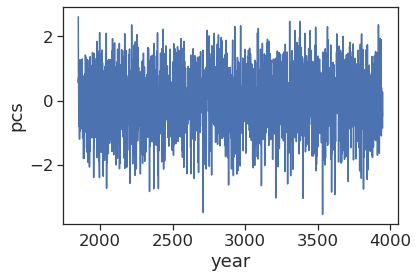

In [88]:
pc1_nao.plot()

Text(0.5, 1.0, 'PC1 (11-year running mean)')

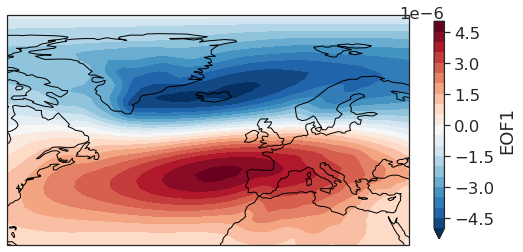

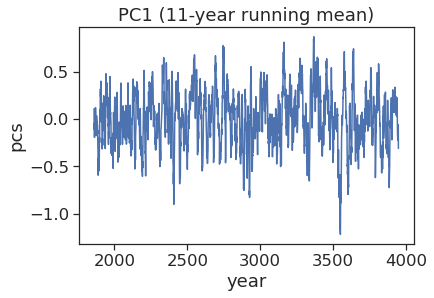

In [36]:

fig1, ax1 = plt.subplots(1,1, figsize=(9,5),
                         subplot_kw={'projection':ccrs.PlateCarree()})
cbar_kwargs = {'label':'EOF1', 'extend':'both','shrink':0.8}
eof1_nao.sel(mode=0).plot.contourf(ax=ax1, 
                               cbar_kwargs=cbar_kwargs,
                               levels=np.linspace(-5e-6, 5e-6, 21),
                               transform=ccrs.PlateCarree())
ax1.coastlines()

fig2, ax2 = plt.subplots(1,1)
pc1_nao.rolling(year=11).mean().plot(ax=ax2)
ax2.set_title('PC1 (11-year running mean)')

## Heat flux as Gulev

In [37]:
def hflux(flux):
    # As Gulev
    #lon1, lon2, lat1, lat2 = -50, -25, 35, 55
    
    # New definition where our heat flux anomalies peak
    #lon1, lon2, lat1, lat2 = -55, 0, 50, 65
    #lon1, lon2, lat1, lat2 = -30, 0, 50, 65
    lon1, lon2, lat1, lat2 = -30, -10, 50, 60
    res = wgtm( flux.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return res

thf = (ds_sfc_1y['sshf'] + ds_sfc_1y['slhf']) / (6*60*60) # W/m2
thf_180 = thf.assign_coords(lon=(((thf['lon'] + 180) % 360) - 180)).sortby('lon')
thf_gulev = hflux(thf_180).groupby('time.year').mean('time').compute()

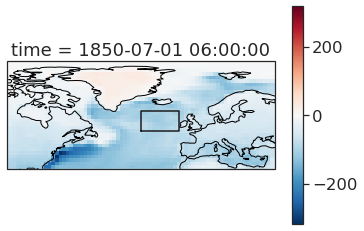

In [38]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
thf[0,:,:].plot(ax=ax)
lon1, lon2, lat1, lat2 = -30, -10, 50, 60
ax.plot([lon1, lon2, lon2, lon1, lon1],[lat1, lat1, lat2, lat2, lat1], '-k')
ax.coastlines()
ax.set_extent([-100,40,30,80])

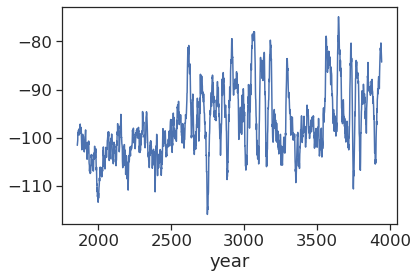

In [39]:
thf_gulev.rolling(year=11,center=True).mean().plot()

In [40]:
thf_gulev.name = 'thf_gulev'
_ds = thf_gulev.to_dataset()
_ds.to_netcdf('data/thf_gulev_1850-3950.nc')

In [20]:
# Read from file
_ds = xr.open_dataset('data/thf_gulev_1850-3950.nc')
thf_gulev = _ds['thf_gulev']

### AMOC

In [42]:
# What latitude to use
#amoc_lat = 45
#amoc_lat = 26.5

# Latitudes from NEMO grid
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values

# Find j index closest to 26.5 and 45
amoc_j26 = np.argmin( np.abs(nav_lat - 26.5) )
print(amoc_j26, nav_lat[amoc_j26])

amoc_j45 = np.argmin( np.abs(nav_lat - 45) )
print(amoc_j45, nav_lat[amoc_j45])

# Take max stream function at specified latitude
# Then take annual means 
amoc26 = ds_moc['zomsfatl'].sel(x=0,y=amoc_j26).max('depthw').groupby('time.year').mean('time').drop('lat').compute()
amoc45 = ds_moc['zomsfatl'].sel(x=0,y=amoc_j45).max('depthw').groupby('time.year').mean('time').drop('lat').compute()
amoc26_anom = amoc26 - amoc26.mean('year')    
amoc45_anom = amoc45 - amoc45.mean('year')  

303 26.279882
349 45.081944


In [43]:
amoc26

amoc26.name = 'amoc26'
amoc45.name = 'amoc45'
ds_amoc26 = amoc26.to_dataset()
ds_amoc45 = amoc45.to_dataset()
ds_amoc26.to_netcdf('data/amoc26.nc')
ds_amoc45.to_netcdf('data/amoc45.nc')

In [21]:
amoc26 = xr.open_dataset('data/amoc26.nc')['amoc26']
amoc45 = xr.open_dataset('data/amoc45.nc')['amoc45']

### AMV

In [22]:
def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

def amv(sst):
    #lon1 = 290
    #lon2 = 360
    #lat1 = 40
    #lat2 = 70
    lon1, lon2, lat1, lat2 = 280, 360, 0, 65
    amv = wgtm( sst.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return amv

# Compute AMV index
_amv = amv(ds_sfc_1m['sstk']).compute()
    
# Annual mean
# (Note, AMV is usually defined using a 11-year running mean to avoid sub-decadal modes)
amv = _amv.groupby('time.year').mean('time')

NameError: name 'ds_sfc_1m' is not defined

In [46]:
amv.name = 'amv'
ds_amv = amv.to_dataset()
ds_amv.to_netcdf('data/amv.nc')

In [23]:
amv = xr.open_dataset('data/amv.nc')['amv']
amv

<xarray.DataArray 'amv' (year: 2100)>
array([288.29095, 287.90283, 287.96667, ..., 287.11154, 287.13034, 287.24478],
      dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949

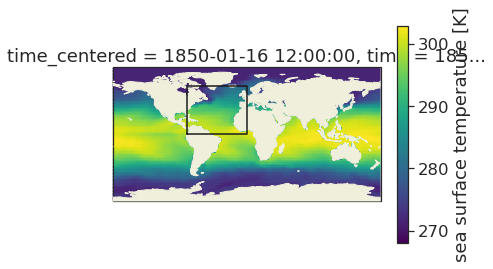

In [48]:
fig,ax=plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
ds_sfc_1m['sstk'].isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=100)
#ax.plot([-70,0,0,-70,-70],[40,40,70,70,40],'-k',zorder=200)
ax.plot([-80,0,0,-80,-80],[0,0,65,65,0],'-k',zorder=200)
#ax.set_extent([-100,40,0,90])
ax.set_global()

## Sea-ice area

In [49]:
# Take sea ice fraction from OpenIFS and add latitude weights
ci = ds_sfc_1m['ci']

# NH 
ci_nh = ci.sel(lat=slice(0,90))
ci_nh = ci.sel(lat=slice(0,90))
# SH
ci_sh = ci.sel(lat=slice(-90,0))
ci_sh = ci.sel(lat=slice(-90,0))

w_nh = np.cos(np.deg2rad(ci_nh.lat))
w_nh.name = "weights"
w_sh = np.cos(np.deg2rad(ci_sh.lat))
w_sh.name = "weights"

# Earth is 510.1 million km2
# NH and SH are half
scale = 510.1/2.0

# Select Feb and Sep sea ice, add weights, and area-average
# Unit will be million km2
ci_nh_feb = ci_nh.sel(time=ci_nh.time.dt.month.isin([2])).groupby('time.year').mean('time').weighted(w_nh).mean(('lon','lat')) * scale
ci_nh_sep = ci_nh.sel(time=ci_nh.time.dt.month.isin([9])).groupby('time.year').mean('time').weighted(w_nh).mean(('lon','lat')) * scale

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWa

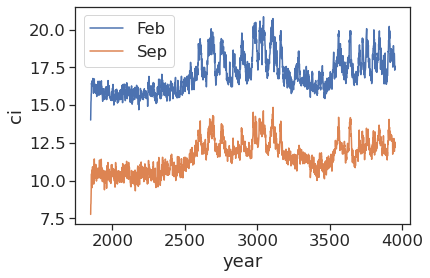

In [50]:
ci_nh_feb.compute()
ci_nh_sep.compute()

fig1, ax1 = plt.subplots(1,1)
ci_nh_feb.plot(ax=ax1,label='Feb')
ci_nh_sep.plot(ax=ax1,label='Sep')
ax1.legend()

In [51]:
# Save 
ci_nh_feb.name = 'ci_nh_feb'
ci_nh_sep.name = 'ci_nh_sep'
_ds1 = ci_nh_feb.to_dataset()
_ds2 = ci_nh_sep.to_dataset()
_ds = xr.merge([_ds1,_ds2])
_ds.to_netcdf('data/Arctic_SIA_1850-3950.nc')

In [24]:
_ds = xr.open_dataset('data/Arctic_SIA_1850-3950.nc')
ci_nh_feb = _ds['ci_nh_feb']
ci_nh_sep = _ds['ci_nh_sep']

## Define phases

In [25]:
label_list = ['Phase1','Phase2','Phase3']
#period_list = [slice('2200-01-01','2500-01-01'), slice('2600-01-01','3200-01-01'), slice('3200-01-01','3500-01-01')]
#period_list_yr = [slice(2200,2500), slice(2600,3200), slice(3200,3500)]

#period_list = [slice('2200-01-01','2550-01-01'), slice('2550-01-01','3300-01-01'), slice('3300-01-01','3550-01-01')]
#period_list_yr = [slice(2200,2550), slice(2550,3300), slice(3300,3500)]

# New definition of phases based on analysing PC1
periods = [ [2000,2450], [2550,3150], [3300,3510] ]
period_list = []
period_list_yr = []
for p in periods:
    period_list.append(slice('%d-01-01' % (p[0],), '%d-01-01' % (p[1],)))
    period_list_yr.append(slice(p[0],p[1]))

## Define correlation 

In [26]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def correlation(x, y, dim='time'):
    cov = ((x - x.mean(dim=dim))* (y - y.mean(dim=dim))).mean(dim=dim)
    corr = cov / x.std(dim=dim) / y.std(dim=dim)
    return corr

def significance(r,n):
    t = r / np.sqrt(1 - r**2) * np.sqrt((n - 2).where(n > 2))
    p_values = t.copy()
    p_values.values = (2 
                       * sns.distributions.stats.t.sf(
                       np.abs(t.where(n>2)),
                       df=n.where(n>2)-2))
    return p_values

## Lagged correlation of AMOC, AMV

In [27]:
def lag_corr(x, y, shiftx=0, shifty=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if shiftx != 0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = shiftx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if shifty!=0:
        y   = y.shift(time = shifty).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    cor   = xr.DataArray(cor, dims=cov.dims, coords=cov.coords)
    slope   = xr.DataArray(slope, dims=cov.dims, coords=cov.coords)
    pval   = xr.DataArray(pvalue, dims=cov.dims, coords=cov.coords)
    stderr   = xr.DataArray(stderr, dims=cov.dims, coords=cov.coords)
    
    return cov,cor,slope,intercept,pval,stderr

In [28]:
# Lists where we put the results
cor_list2 = [] # correlation (-1,1)
k_list2 = [] # regression (e.g. K/Sv)
p_list2 = [] # pvalues
    
#varnames = ['amoc26','nao','thf','nao-curl']
#var_list = [amoc26, pc1_nao, thf_gulev, da_curl_spg_1y] 
varnames = ['amoc26','nao','nh_feb','thf']
var_list = [amoc26, pc1_nao, ci_nh_feb, thf_gulev]
#varnames = ['amoc26','denmark','fram']
#var_list = [amoc26, ds_trp.sel(section='DENMARK_STRAIT'), ds_trp.sel(section='FRAM')]
    
for jv, _da in enumerate( var_list ):
    
    # Lists where we put the results
    cor_list = [] # correlation (-1,1)
    k_list = [] # regression (e.g. K/Sv)
    p_list = [] # pvalues
    
    # Bandpass 20-100
    run1, run2 = 20, 100
    if varnames[jv] == 'nao-spg' or varnames[jv] == 'nao-curl':
        # use NAO as PC
        _pc1 = pc1_nao.rolling(year=run1,center=True).mean() - pc1_nao.rolling(year=run2,center=True).mean()
    else:
        # use AMV as PC
        _pc1 = pc1_sst.rolling(year=run1,center=True).mean() - pc1_sst.rolling(year=run2,center=True).mean()
    
    _da2  = _da.rolling(year=run1,center=True).mean() - _da.rolling(year=run2,center=True).mean()
    print(_da2)
    
    # Loop over the phases
    for jp, period in enumerate(period_list_yr):
    
        # List of all correlations
        da_r = []
        da_p = []
        da_k = []
        
        # Select period
        # Rename to time for the function
        _x = _pc1.sel(year=period).rename({'year':'time'}) 
        _y = _da2.sel(year=period).rename({'year':'time'}) 
            
        # Detrend
        xd = detrend(_x.load(), dim='time')
        yd = detrend(_y.load(), dim='time')
        
        # Loop over lags
        # lag < 0 -> AMOC leads
        # lag > 0 -> AMOC lags
        for lagx in range(-60,61):
        
            # Linear regression
            _cov, _cor, _k, _m, _p, _std = lag_corr(xd, yd, shiftx=lagx)
            
            # Add lag as dimension and append to list
            _cor['lag'] = lagx
            _p['lag'] = lagx
            _k['lag'] = lagx 
            
            da_r.append(_cor)
            da_p.append(_p)
            da_k.append(_k)
        
        # Merge along lag dimension
        cor = xr.concat(da_r,dim='lag')
        pval = xr.concat(da_p,dim='lag')
        k = xr.concat(da_k,dim='lag')
        
        cor['period'] = jp
        pval['period'] = jp
        k['period'] = jp
        
        # Save 
        cor_list.append(cor)
        p_list.append(pval)
        k_list.append(k)
    
    cor = xr.concat(cor_list, dim='period')
    pval = xr.concat(p_list, dim='period')
    k = xr.concat(k_list, dim='period')
    
    cor.name = '%s' % (varnames[jv],)
    pval.name = '%s' % (varnames[jv],)
    k.name = '%s' % (varnames[jv],)
    ds_cor = cor.to_dataset()
    ds_p = pval.to_dataset()
    ds_k = k.to_dataset()
    
    # Save 
    cor_list2.append(ds_cor)
    p_list2.append(ds_p)
    k_list2.append(ds_k)
    
cor = xr.merge(cor_list2, compat='override')
pval = xr.merge(p_list2, compat='override')
k = xr.merge(k_list2, compat='override')

<xarray.DataArray 'amoc26' (year: 2100)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949
<xarray.DataArray 'pcs' (year: 2099)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3944 3945 3946 3947 3948
<xarray.DataArray 'ci_nh_feb' (year: 2100)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949
<xarray.DataArray 'thf_gulev' (year: 2100)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 3945 3946 3947 3948 3949


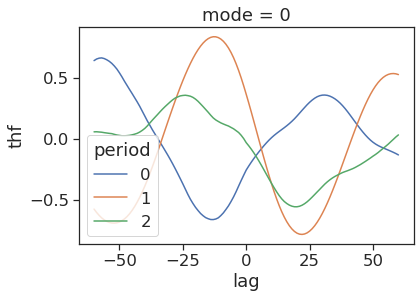

In [57]:
cor['thf'].plot(hue='period')
#fig = plt.gcf()
#fig.savefig('figures/NAO-curl_lag.pdf',format='pdf')

Phase1, peak at lag=-17.000000
Phase2, peak at lag=8.000000
Phase1, peak at lag=20.000000
Phase2, peak at lag=20.000000
Phase1, peak at lag=-20.000000
Phase2, peak at lag=20.000000
Phase1, peak at lag=20.000000
Phase2, peak at lag=-13.000000


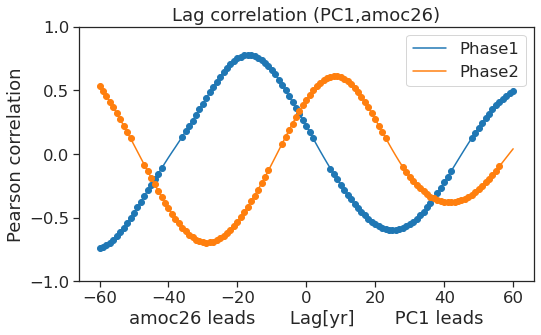

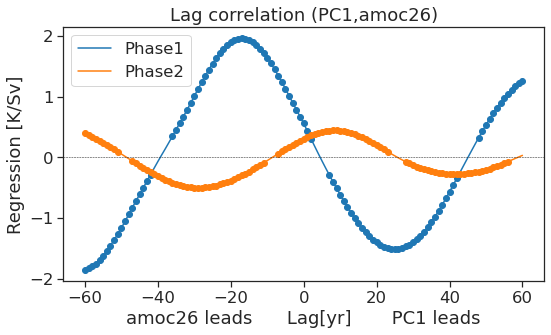

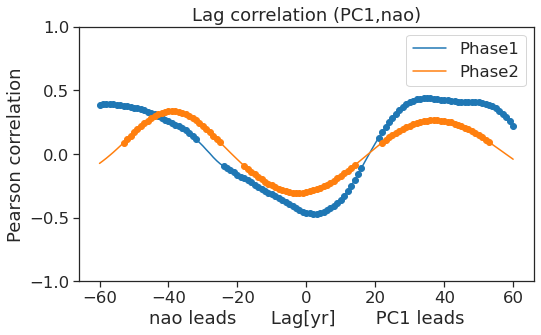

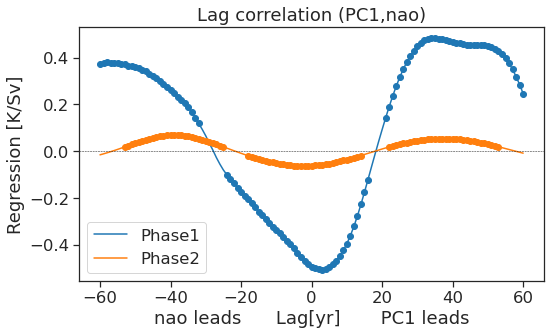

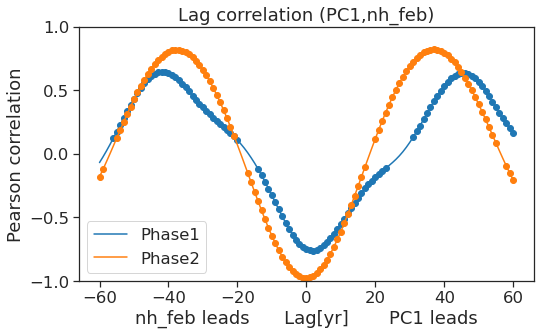

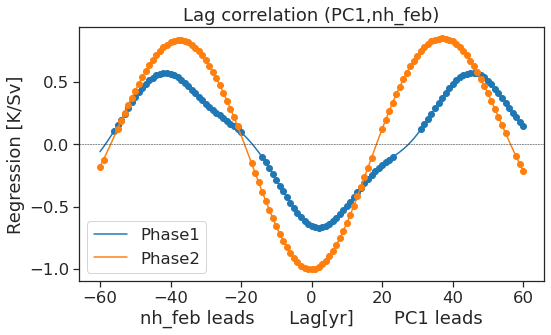

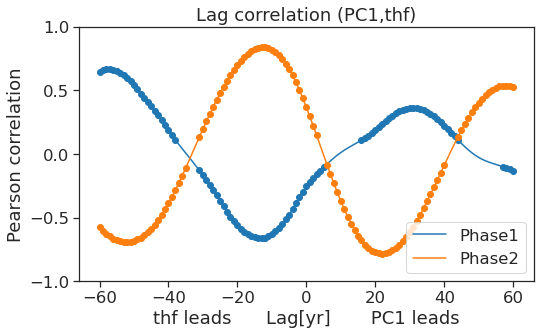

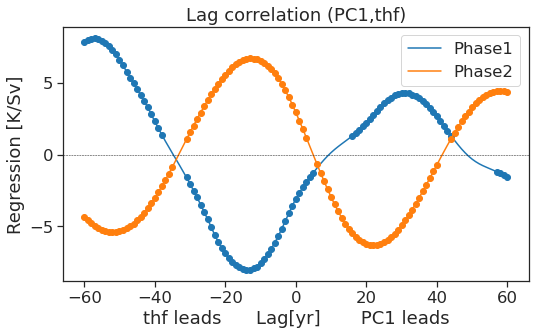

In [58]:
c_list = ['tab:blue','tab:orange','tab:green','tab:red']

for jv, var in enumerate(varnames):
    
    da_cor = cor[var]
    da_k = k[var]
    da_pval = pval[var]

    fig1, ax1 = plt.subplots(1,1,figsize=(8,5))
    fig2, ax2 = plt.subplots(1,1,figsize=(8,5))
    
    for jc, per in enumerate( period_list_yr[0:2] ):
        
        _cor = da_cor.sel(period=jc)
        _k = da_k.sel(period=jc)
        _p = da_pval.sel(period=jc)
        
        _cor.plot(ax=ax1, label=label_list[jc], c=c_list[jc])
        _cor.where(_p<0.05).plot(ax=ax1,marker='o',lw=0,c=c_list[jc])
        
        _k.plot(ax=ax2, label=label_list[jc], c=c_list[jc])
        _k.where(_p<0.05).plot(ax=ax2,marker='o',lw=0,c=c_list[jc])
        
        print('%s, peak at lag=%f' % (label_list[jc],_cor.sel(lag=slice(-20,20)).idxmax('lag')))
    
    ax1.set_ylim([-1,1])
    ax1.legend()
    ax1.set_ylabel('Pearson correlation')
    ax1.set_title('Lag correlation (PC1,%s)' % (var,))
    ax1.set_xlabel('%s leads      Lag[yr]       PC1 leads' % (var,));
    fig1.tight_layout()
    fig1.savefig('figures/PC1_%s_lag_corr_20-100yr.pdf' % (var,),format='pdf')
    
    ax2.legend()
    #ax2.set_ylim([-0.2,0.2])
    ax2.axhline(y=0, linestyle='--', color='k', lw=0.5)
    ax2.set_ylabel('Regression [K/Sv]')
    ax2.set_title('Lag correlation (PC1,%s)' % (var,))
    ax2.set_xlabel('%s leads      Lag[yr]       PC1 leads' % (var,));
    fig2.tight_layout()
    fig2.savefig('figures/PC1_%s_lag_slope_20-100yr.pdf' % (var,),format='pdf')
    

## Plot correlation with AMOC, NAO, Arctic SIA and THF

Phase1, peak at lag=-17.000000
Phase2, peak at lag=8.000000
Phase1, peak at lag=20.000000
Phase2, peak at lag=20.000000
Phase1, peak at lag=-20.000000
Phase2, peak at lag=20.000000
Phase1, peak at lag=20.000000
Phase2, peak at lag=-13.000000


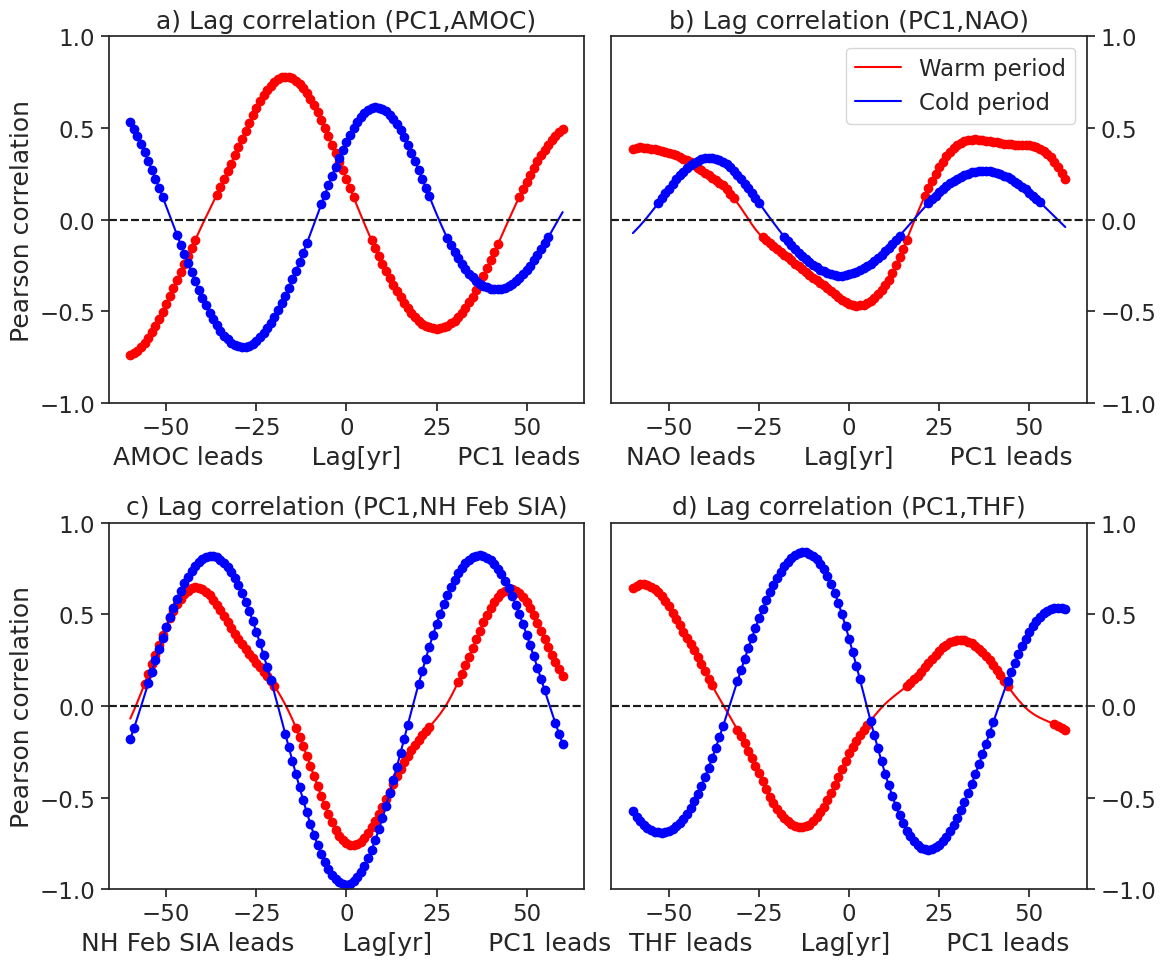

In [32]:
#c_list = ['tab:red','tab:blue','tab:green']
if dark == '':
    c_list = ['red','blue','green']
    w = 'k'
else:
    #c_list = ['orangered','cornflowerblue']
    c_list = ['tab:red','tab:blue','tab:green']
    w = 'w'

label_list2 = ['Warm period', 'Cold period']

nice_varnames = ['AMOC','NAO','NH Feb SIA','THF']
x_varnames = ['PC1','PC1','PC1','PC1']

fig1, axs1 = plt.subplots(2,2, figsize=(12,10))
ax1 = axs1.flat

letters = ['a','b','c','d']

for jv, var in enumerate(varnames):
    
    da_cor = cor[var]
    da_k = k[var]
    da_pval = pval[var]
    
    ax = ax1[jv]
    
    var2 = nice_varnames[jv]
    var22 = x_varnames[jv]
    
    for jc, per in enumerate( period_list_yr[0:2] ):
        
        _cor = da_cor.sel(period=jc)
        _k = da_k.sel(period=jc)
        _p = da_pval.sel(period=jc)
        
        if np.mod(jv,2) > 0:
            ax.yaxis.tick_right()
        
        _cor.plot(ax=ax, label=label_list2[jc], c=c_list[jc])
        _cor.where(_p<0.05).plot(ax=ax,marker='o',lw=0,c=c_list[jc])
        
        ax.axhline(y=0, linestyle='dashed',color=w)
        
        print('%s, peak at lag=%f' % (label_list[jc],_cor.sel(lag=slice(-20,20)).idxmax('lag')))
    
    ax.set_ylim([-1,1])
    if jv == 1:
        ax.legend()
    if np.mod(jv,2) == 0:
        ax.set_ylabel('Pearson correlation')
    else:
        ax.set_ylabel('')
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_title('%s) Lag correlation (PC1,%s)' % (letters[jv],var2))
    ax.set_xlabel('%s leads      Lag[yr]       %s leads' % (var2,var22));

#ax1[0].set_title('Lag correlation (PC1,AMOC)')
#ax1[1].set_title('Lag correlation (PC1,NAO)')
#ax1[2].set_title('Lag correlation (PC1,Arctic SIA)')
#ax1[3].set_title('Lag correlation (NAO,Curl)')

fig1.tight_layout()
fig1.savefig('figures/PC1_lag_corr4_20-100yr%s.pdf' % (dark,),format='pdf')    